## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.



    Load your data into Tetrad, generating a Dataset object.
    Feed your data into a Search Algorithm.
    Choose search settings/assumptions that make sense, given how your data were collected.
    The output will be an equivalence class of graphs. Choose one plausible DAG from the output equivalence class.
    Choose a parametric model that makes sense for your data.
    Use your dataset to learn the parameters of the instantiated model.


# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})



def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 0

'''
models = [#[8,8,4],
          #[16,16,8],
          #LogisticRegression(), 
          #Perceptron(),  
          #DecisionTreeClassifier(),
          #LinearSVC(),
          #GaussianNB(),
          #[32,32,16],
          #[64,64,32],
          #[128, 128, 64],
          #[256, 256, 128],
          #[512, 512, 256],
          #[1024, 1024, 512],
          [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024], 
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
          #[2048, 2048, 1024],
         ]
model_names = ['n1', 
               'n2',
               'n3',
                'n4', 
               'n5',
               'n6',
                'n7', 
               'n8',
               'n9',

               #'m7', 
               #'m8',
               #'m9',
               #'m10', 
               #'m11a',
               #'m11b',
               #'m11c',
              ]
'''


models = []
model_names = []

num_models = 50
model_layers = [512, 256]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/b' + str(i))

print(models, model_names)


df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data(SIZE = 2000)
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values




/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/b0', 'temp/b1', 'temp/b2', 'temp/b3', 'temp/b4', 'temp/b5', 'temp/b6', 'temp/b7', 'temp/b8', 'temp/b9', 'temp/b10', 'temp/b11', 'temp/b12', 'temp/b13', 'temp/b14', 'temp/b15', 'temp/b16', 'temp/b17', 'temp/b18', 'temp/b19', 'temp/b20', 'temp/b21', 'temp/b22', 'temp/b23', 'temp/b24', 'temp/b25', 'temp/b26', 'temp/b27', 'temp/b28', 'temp/b29', 'temp/b30', 'temp/b31', 'temp/b32', 'temp/b33', 

In [ ]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


In [3]:
## the size of the test set
nb_test = 2000


metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0,1,2]
variances = [1, 2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


In [4]:
#the number of times to sample 
times = 5
## the size of the test set
nb_test = 2000

## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

#metrics_dicts = []
causal_dicts = []
for m in models:
#    metrics_dicts.append(defaultdict(list))
    causal_dicts.append(defaultdict(list))
from pycausal import prior as p
def get_bic(df):
    prior = p.knowledge(requiredirect =  [['a', 'f'], 
                                      ['b', 'f'], 
                                      ['c', 'f'],
                                      ['d', 'f'], 
                                      ['e', 'f'], 
                                      ['f', 'g']
                                     ])
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC / len(df)

for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    bic_orig = get_bic(df_test)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test))  
        bic_pred = get_bic(test_df)
        violation_mean[idx][t] =bic_pred
        violation_mean2[idx][t] = bic_pred
        print(bic_orig, bic_pred)
        #print(bic_orig - bic_pred)



Times =  0
-3.477586895497852 -3.2902890848625526
-3.477586895497852 -3.2636640025324604
-3.477586895497852 -3.270254740858498
-3.477586895497852 -3.2022456034957645
-3.477586895497852 -3.2768900998854322
-3.477586895497852 -3.2656831616596884
-3.477586895497852 -3.275578184279689
-3.477586895497852 -3.24095943833603
-3.477586895497852 -3.3059244420413205
-3.477586895497852 -3.2251590420542935
-3.477586895497852 -3.2653324843344347
-3.477586895497852 -3.2584831765610494
-3.477586895497852 -3.2167671307816015
-3.477586895497852 -3.266655415568591
-3.477586895497852 -3.2617205411053076
-3.477586895497852 -3.266133568979231
-3.477586895497852 -3.2928076938023056
-3.477586895497852 -3.2973204846978845
-3.477586895497852 -3.217868003880373
-3.477586895497852 -3.3095325165743144
-3.477586895497852 -3.2006371166241685
-3.477586895497852 -3.26059217786989
-3.477586895497852 -3.2212533452097394
-3.477586895497852 -3.273955391749283
-3.477586895497852 -3.297557752676693
-3.477586895497852 -3.229

-3.610243976947153 -3.4087017930934826
-3.610243976947153 -3.409892916792484
-3.610243976947153 -3.3582158509495685
-3.610243976947153 -3.427916541017752
-3.610243976947153 -3.382218025246284
-3.610243976947153 -3.411463574353848
-3.610243976947153 -3.41794709181459
-3.610243976947153 -3.426466695956604
-3.610243976947153 -3.395855493447376
-3.610243976947153 -3.450726369937691
-3.610243976947153 -3.3303763667684585
-3.610243976947153 -3.4005374472543064
-3.610243976947153 -3.3514651157649773
-3.610243976947153 -3.4387504389804415
-3.610243976947153 -3.4543908845662337
-3.610243976947153 -3.378290553549016
-3.610243976947153 -3.461873938127313
-3.610243976947153 -3.3382790383716374
-3.610243976947153 -3.46107622152121
-3.610243976947153 -3.396289572711822
-3.610243976947153 -3.438102261559282
-3.610243976947153 -3.3901168687764756
-3.610243976947153 -3.4123558679963724
-3.610243976947153 -3.380025997606887
-3.610243976947153 -3.488319803004817
-3.610243976947153 -3.3568213371523354
-3.

In [ ]:
tetrad.scores

Model_name =  temp/b0 Violations =  0.0
Average_violations =  -3.337744015239598 0.08503356364501335
MSE =  1.0490287330808616 0.034192770803155546
Model_name =  temp/b1 Violations =  0.0
Average_violations =  -3.3232656569818624 0.07765618061938001
MSE =  1.0513574216917978 0.02872741316529039
Model_name =  temp/b2 Violations =  0.0
Average_violations =  -3.3173537864944533 0.08874322392410783
MSE =  1.0583258188928768 0.0320415036262828
Model_name =  temp/b3 Violations =  0.0
Average_violations =  -3.242206468752613 0.08151908232768318
MSE =  1.0701626561604174 0.036958720315708384
Model_name =  temp/b4 Violations =  0.0
Average_violations =  -3.331198156224533 0.08335587427465449
MSE =  1.0538116614971131 0.031234831367453746
Model_name =  temp/b5 Violations =  0.0
Average_violations =  -3.321181310613896 0.07363099721538172
MSE =  1.0578530232545522 0.037569154310523246
Model_name =  temp/b6 Violations =  0.0
Average_violations =  -3.319769628415112 0.06904373464008046
MSE =  1.058

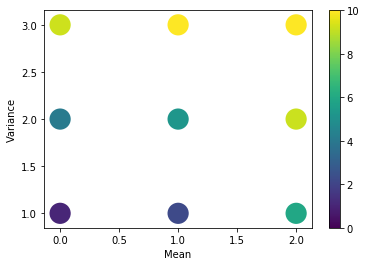

temp/b1
Area under surface (rectangular approx) =  64.01597028965514
Violations =  0.0
Average_violations =  -3.3232656569818624
MSE =  1.0513574216917978


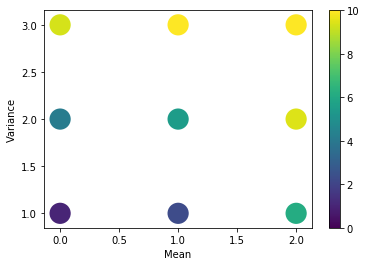

temp/b2
Area under surface (rectangular approx) =  63.15906181187783
Violations =  0.0
Average_violations =  -3.3173537864944533
MSE =  1.0583258188928768


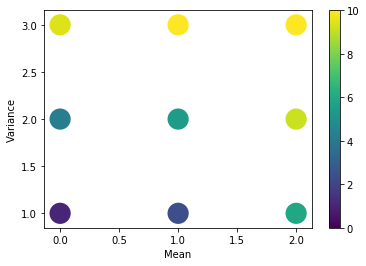

temp/b3
Area under surface (rectangular approx) =  66.20975704626163
Violations =  0.0
Average_violations =  -3.242206468752613
MSE =  1.0701626561604174


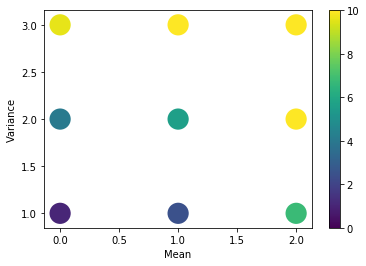

temp/b4
Area under surface (rectangular approx) =  63.22550265067973
Violations =  0.0
Average_violations =  -3.331198156224533
MSE =  1.0538116614971131


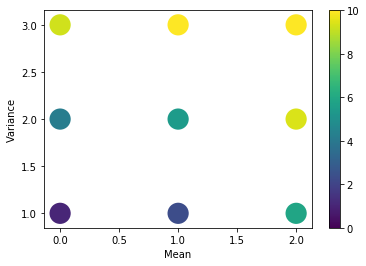

temp/b5
Area under surface (rectangular approx) =  60.14177115597292
Violations =  0.0
Average_violations =  -3.321181310613896
MSE =  1.0578530232545522


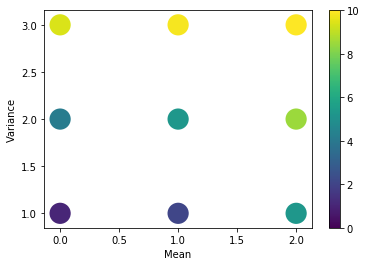

temp/b6
Area under surface (rectangular approx) =  62.94683514790313
Violations =  0.0
Average_violations =  -3.319769628415112
MSE =  1.0582091157084048


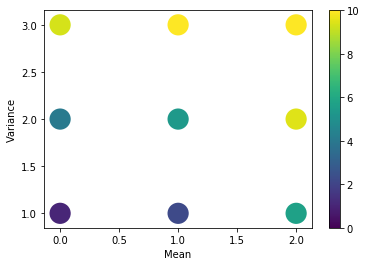

temp/b7
Area under surface (rectangular approx) =  62.65272584887341
Violations =  0.0
Average_violations =  -3.2887641009949897
MSE =  1.0706333171756748


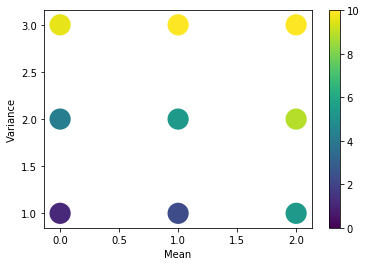

temp/b8
Area under surface (rectangular approx) =  57.48470837456236
Violations =  0.0
Average_violations =  -3.357502080923313
MSE =  1.0647660251523603


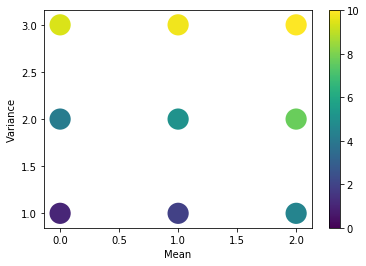

temp/b9
Area under surface (rectangular approx) =  63.3882882819548
Violations =  0.0
Average_violations =  -3.298670525589729
MSE =  1.0686069709488297


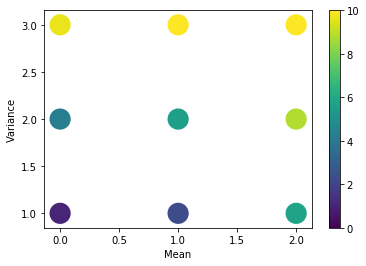

temp/b10
Area under surface (rectangular approx) =  66.5919153231963
Violations =  0.0
Average_violations =  -3.324691827979337
MSE =  1.0501634014063932


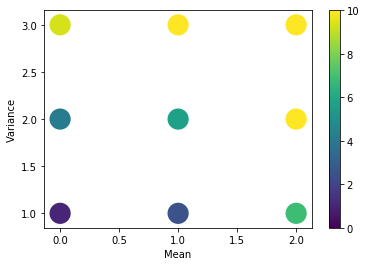

temp/b11
Area under surface (rectangular approx) =  68.5528217986921
Violations =  0.0
Average_violations =  -3.314724852083445
MSE =  1.0596484840852791


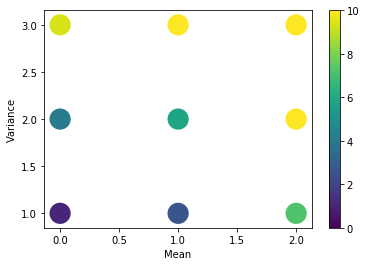

temp/b12
Area under surface (rectangular approx) =  67.73169687578978
Violations =  0.0
Average_violations =  -3.2663908883634214
MSE =  1.0582937850598284


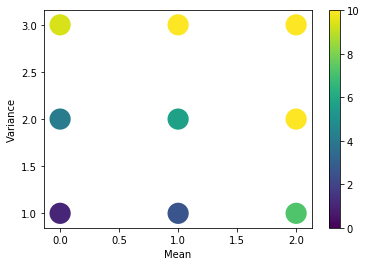

temp/b13
Area under surface (rectangular approx) =  62.905967750748594
Violations =  0.0
Average_violations =  -3.317849787477828
MSE =  1.0562062158747183


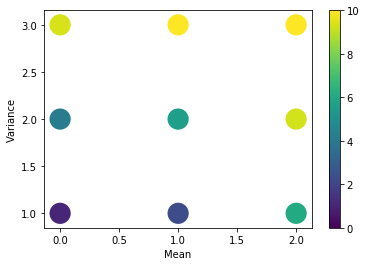

temp/b14
Area under surface (rectangular approx) =  65.89383853578265
Violations =  0.0
Average_violations =  -3.3013655093157035
MSE =  1.0592468693652757


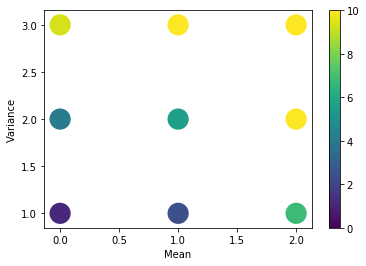

temp/b15
Area under surface (rectangular approx) =  61.11930976313026
Violations =  0.0
Average_violations =  -3.318329845804482
MSE =  1.0676142965644502


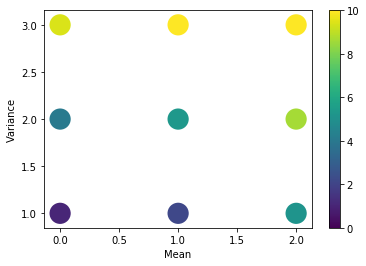

temp/b16
Area under surface (rectangular approx) =  57.94922442962212
Violations =  0.0
Average_violations =  -3.3411933518027594
MSE =  1.0601414994332141


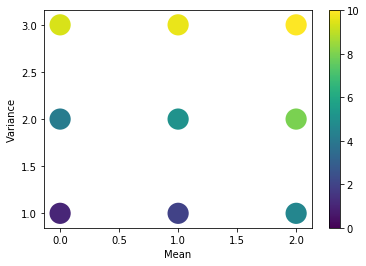

temp/b17
Area under surface (rectangular approx) =  61.23981378677427
Violations =  0.0
Average_violations =  -3.333552231667516
MSE =  1.053416709272742


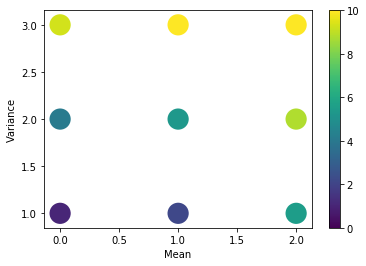

temp/b18
Area under surface (rectangular approx) =  74.55843414165241
Violations =  0.0
Average_violations =  -3.278387926568795
MSE =  1.0665078192717996


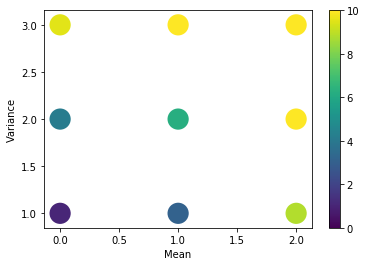

temp/b19
Area under surface (rectangular approx) =  59.99722810336448
Violations =  0.0
Average_violations =  -3.3602328828301493
MSE =  1.0574499361159355


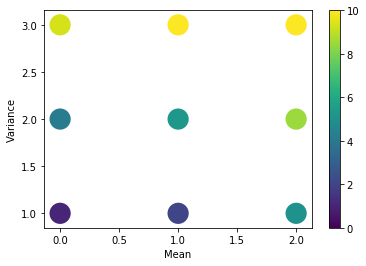

temp/b20
Area under surface (rectangular approx) =  66.7064051096666
Violations =  0.0
Average_violations =  -3.2680963725132797
MSE =  1.0587649605472138


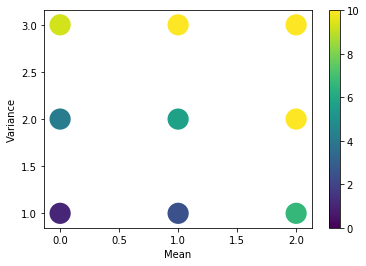

temp/b21
Area under surface (rectangular approx) =  61.97498206249898
Violations =  0.0
Average_violations =  -3.3243948281913362
MSE =  1.0519965156892497


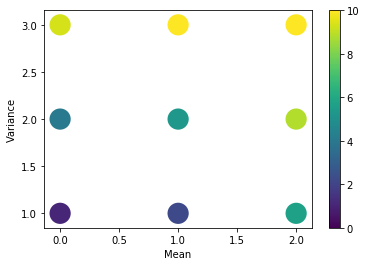

temp/b22
Area under surface (rectangular approx) =  67.41381142884504
Violations =  0.0
Average_violations =  -3.2745085917456307
MSE =  1.0670795064023049


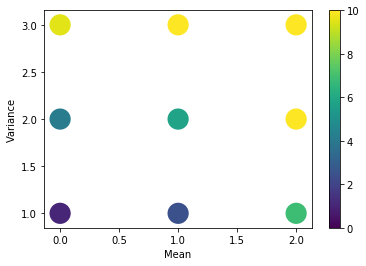

temp/b23
Area under surface (rectangular approx) =  66.73376989477192
Violations =  0.0
Average_violations =  -3.329001442656825
MSE =  1.0623902133272172


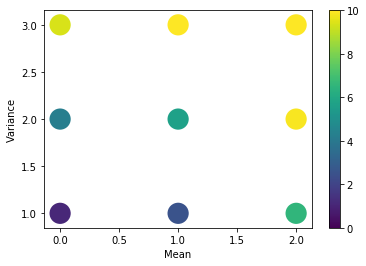

temp/b24
Area under surface (rectangular approx) =  58.881912216144954
Violations =  0.0
Average_violations =  -3.359597583992047
MSE =  1.0473294767568377


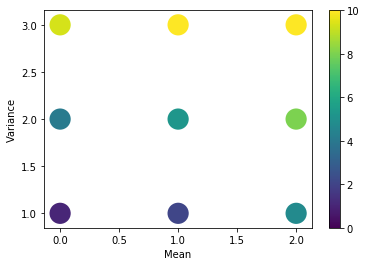

temp/b25
Area under surface (rectangular approx) =  76.1969515834198
Violations =  0.0
Average_violations =  -3.278305706273257
MSE =  1.0627612175257468


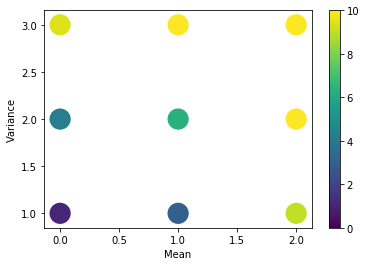

temp/b26
Area under surface (rectangular approx) =  57.59798132173427
Violations =  0.0
Average_violations =  -3.3447887892424157
MSE =  1.0639406084089211


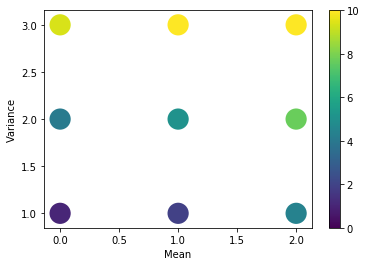

temp/b27
Area under surface (rectangular approx) =  70.93886843503233
Violations =  0.0
Average_violations =  -3.259406208604541
MSE =  1.0713495136459463


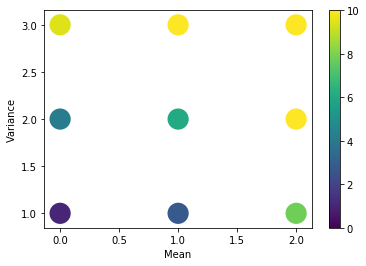

temp/b28
Area under surface (rectangular approx) =  60.903990582327275
Violations =  0.0
Average_violations =  -3.3520259599536475
MSE =  1.0462549411788875


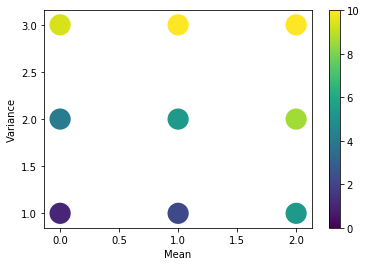

temp/b29
Area under surface (rectangular approx) =  64.99124255014088
Violations =  0.0
Average_violations =  -3.295993939409653
MSE =  1.051224172761124


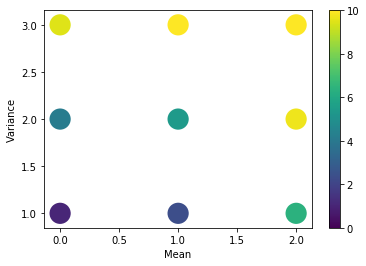

temp/b30
Area under surface (rectangular approx) =  68.31347076512301
Violations =  0.0
Average_violations =  -3.3276367887787215
MSE =  1.0715615460728938


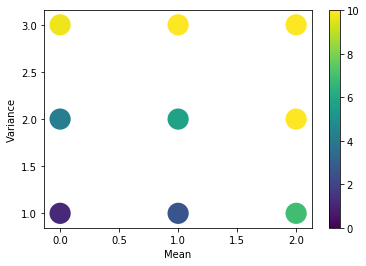

temp/b31
Area under surface (rectangular approx) =  67.4005332323899
Violations =  0.0
Average_violations =  -3.2944930518914988
MSE =  1.0586471930195664


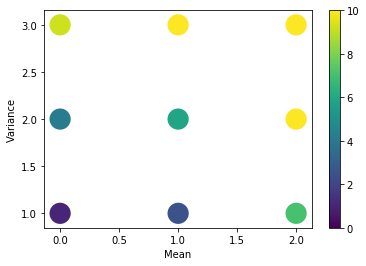

temp/b32
Area under surface (rectangular approx) =  67.55706818418462
Violations =  0.0
Average_violations =  -3.316927618356518
MSE =  1.0570892802120313


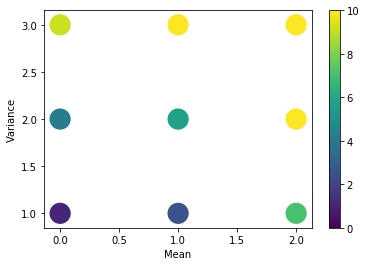

temp/b33
Area under surface (rectangular approx) =  75.55117923487133
Violations =  0.0
Average_violations =  -3.2968961664362553
MSE =  1.0694336733383962


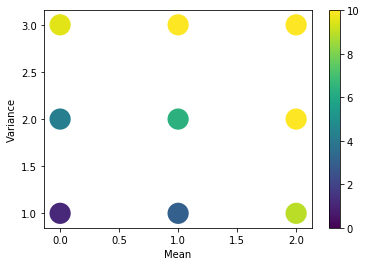

temp/b34
Area under surface (rectangular approx) =  58.49060093787649
Violations =  0.0
Average_violations =  -3.380286091549815
MSE =  1.0427524225169633


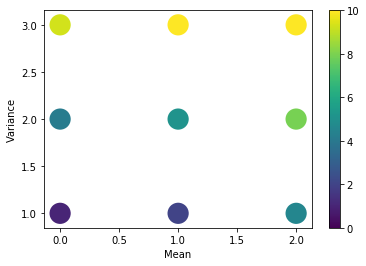

temp/b35
Area under surface (rectangular approx) =  67.88388342736702
Violations =  0.0
Average_violations =  -3.249177445791028
MSE =  1.0683099323937908


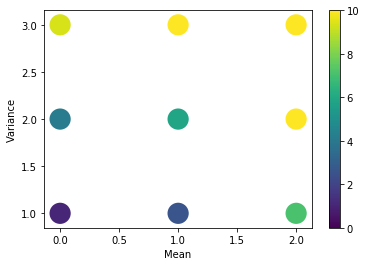

temp/b36
Area under surface (rectangular approx) =  66.42979715909878
Violations =  0.0
Average_violations =  -3.318051438224059
MSE =  1.0617568034379965


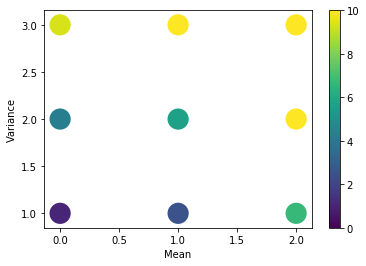

temp/b37
Area under surface (rectangular approx) =  62.94928743448143
Violations =  0.0
Average_violations =  -3.3197647782202915
MSE =  1.06206920047089


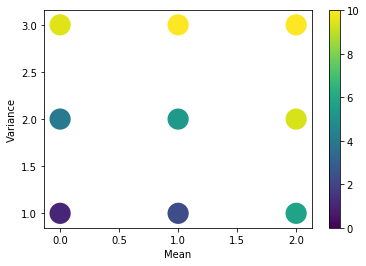

temp/b38
Area under surface (rectangular approx) =  67.12257973249166
Violations =  0.0
Average_violations =  -3.3060043399358903
MSE =  1.0508410146468292


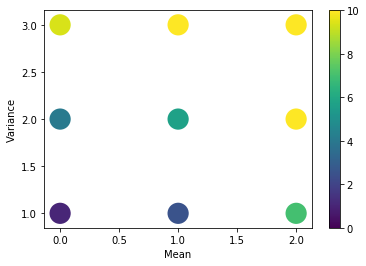

temp/b39
Area under surface (rectangular approx) =  65.26627583300424
Violations =  0.0
Average_violations =  -3.291298484045194
MSE =  1.06588281525285


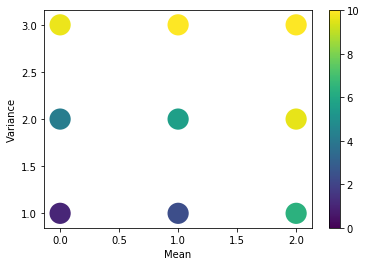

temp/b40
Area under surface (rectangular approx) =  64.31152480331436
Violations =  0.0
Average_violations =  -3.355416287681866
MSE =  1.060341584559806


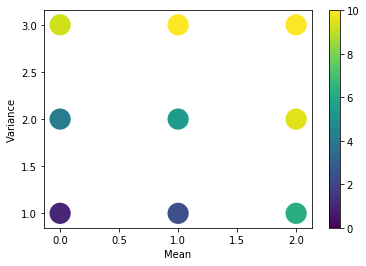

temp/b41
Area under surface (rectangular approx) =  57.86996352045342
Violations =  0.0
Average_violations =  -3.3719548704171083
MSE =  1.0601635492664476


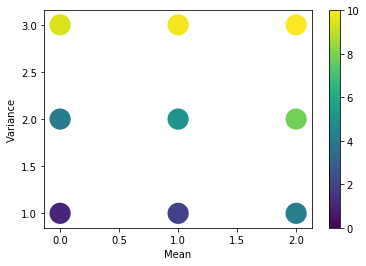

temp/b42
Area under surface (rectangular approx) =  62.71046481372874
Violations =  0.0
Average_violations =  -3.3512889929784087
MSE =  1.0582980228886303


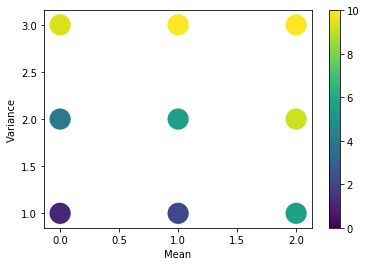

temp/b43
Area under surface (rectangular approx) =  64.27160870360008
Violations =  0.0
Average_violations =  -3.289566906302923
MSE =  1.0491659653927667


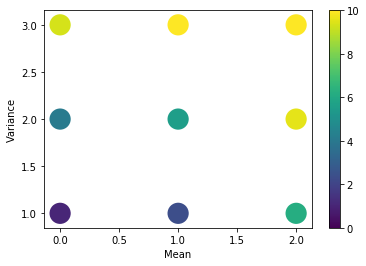

temp/b44
Area under surface (rectangular approx) =  66.30572100960188
Violations =  0.0
Average_violations =  -3.263717112547039
MSE =  1.0526347591486354


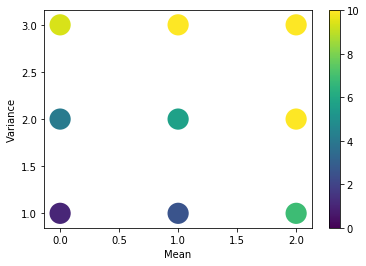

temp/b45
Area under surface (rectangular approx) =  62.9426096149077
Violations =  0.0
Average_violations =  -3.337298193920457
MSE =  1.0551883624901648


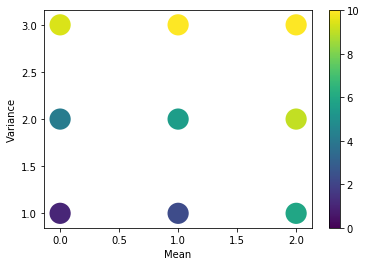

temp/b46
Area under surface (rectangular approx) =  70.23469420238722
Violations =  0.0
Average_violations =  -3.2847270862137328
MSE =  1.0533699944058679


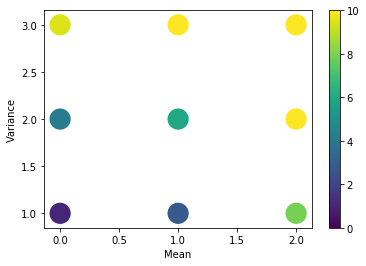

temp/b47
Area under surface (rectangular approx) =  67.80972782448923
Violations =  0.0
Average_violations =  -3.304519280929534
MSE =  1.0699937549268874


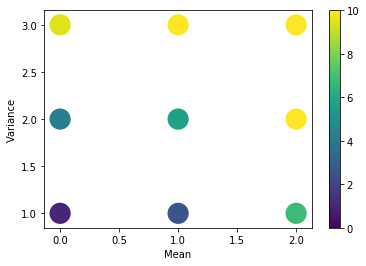

temp/b48
Area under surface (rectangular approx) =  68.38499009239447
Violations =  0.0
Average_violations =  -3.268918606269535
MSE =  1.0582360247480254


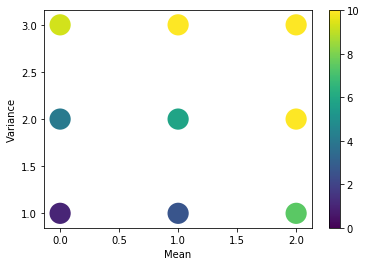

temp/b49
Area under surface (rectangular approx) =  61.35965665798886
Violations =  0.0
Average_violations =  -3.319815116126505
MSE =  1.0518874988300075


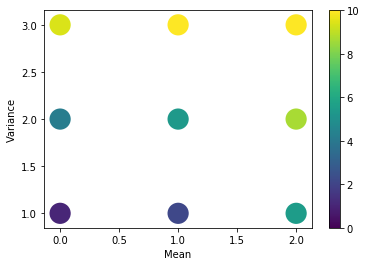

In [7]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

#bar_plot(model_names, 
#         np.array(metric), 
#         np.array(metric_err), 
#         np.array(viol), 
#         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    



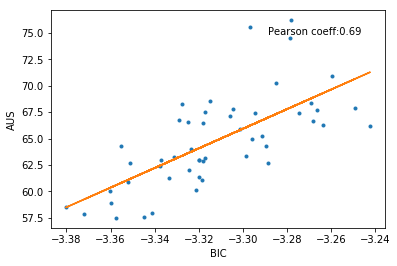

0.6538814942374181


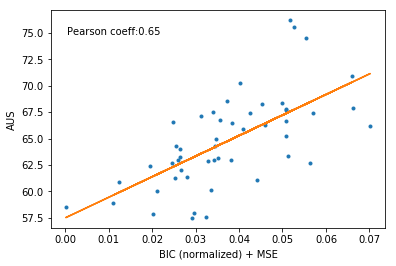

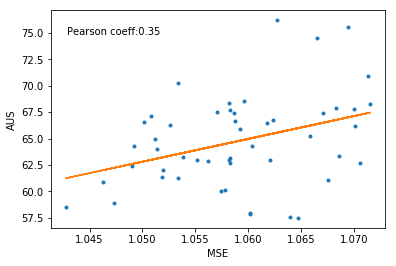

1.3661602469044496 0.09271276965641369


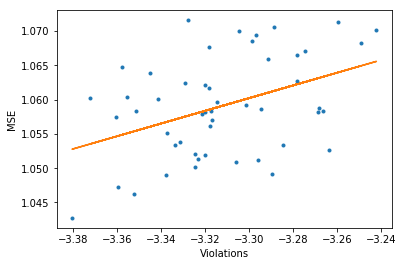

127.33612894301858 -29.19847319328646


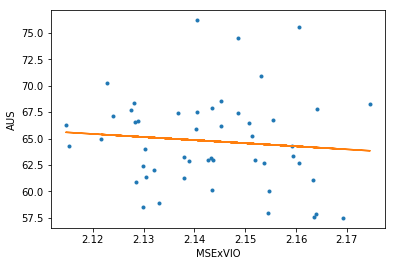

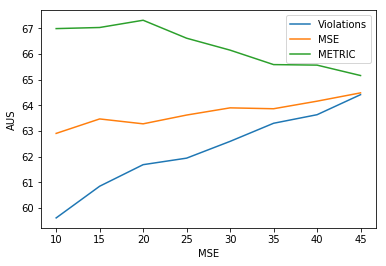

In [10]:
#VIO = 1/np.abs(VIO)
#VIO2 = np.abs(VIO2)
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.65, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex3ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC (normalized) + MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex3ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex3MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()





METRIC = (VIO/np.max(VIO)) + np.array(MSE)*np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
print(b,m)
ax.plot(METRIC,AUS, '.')
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSExVIO")
ax.set_ylabel("AUS")
plt.show()

MSE = np.array(MSE)
METRIC = VIO/np.max(VIO)+ MSE
x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'Violations')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
